In [8]:

import json
from pathlib import Path
from tqdm import tqdm
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic.representation import OpenAI as OpenAI_representation
import datamapplot
import tiktoken
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
import os


In [13]:
# Additional ways of representing a topic
aspect_model1 = PartOfSpeech("en_core_web_sm")
aspect_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]
aspect_model3 = KeyBERTInspired()
tokenizer = tiktoken.encoding_for_model("gpt-4o")


## LOAD DATA

In [20]:
documents = []

with open('./MERA_CODE/rucodereview.jsonl', "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        documents.append(obj['outputs'])

print(f"Загружено документов: {len(documents)}")


Загружено документов: 699


## LLM BASED REPRESENTATION

In [21]:
prompt = """
You are an expert assistant trained to analyze source code review comments and help categorize them. Your task is to generate a short, precise category label based on a list of keywords and representative comments.

Please follow these instructions:
- The label should be **short and descriptive** (between 2 and 5 words).
- It should **summarize the core idea** of the comments, **not just repeat the keywords**.
- The label will be used to **group similar review comments** into categories, so aim for a meaningful and general name that reflects the issue being discussed.
- Avoid vague terms. Be as specific and useful as possible.
- These categories may include style issues, logic flaws, structure suggestions, performance concerns, testing gaps, and more.

Here is the data:
- Keywords: [KEYWORDS]
- Sample review comments:
[DOCUMENTS]

Generate a clear, useful category label that best describes the type of comments shown above.
return in format:
topic: <category label>
"""


In [22]:
from openai import OpenAI
client = OpenAI(
    api_key=os.environ['OPENAI_API_KEY'],
    base_url=os.environ['BASE_URL'],
)

openai_representation = OpenAI_representation(
    client,
    model=os.environ['MODEL'],
    chat=True,
    doc_length=20000,
    tokenizer=tokenizer,
    nr_docs=10,
    prompt = prompt
)

In [23]:
representation_model = {
   "Main": openai_representation,
   "Aspect1":  aspect_model1,
   "Aspect2":  aspect_model2,
   "Aspect3":  aspect_model3
}

## EMBEDDING

In [106]:
model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")
embeddings = model.encode(documents, show_progress_bar=True)

Batches: 100%|██████████| 22/22 [00:27<00:00,  1.26s/it]


## Visualize Optimal cluster number

In [25]:
range_k = range(2, 31)
scores = []
for k in tqdm(range_k, desc="Silhouette search"):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    scores.append(score)

Silhouette search:   0%|          | 0/29 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Silhouette search: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


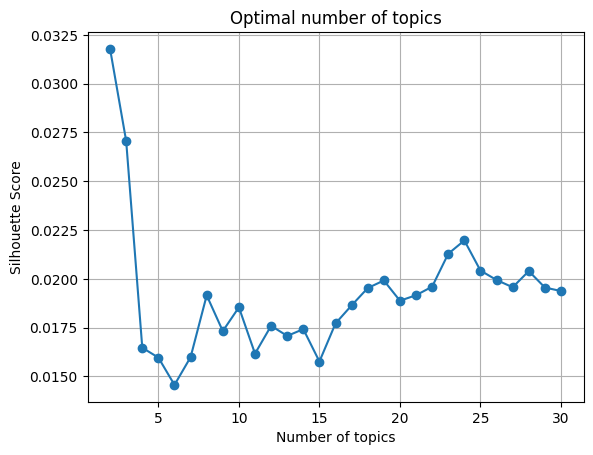

In [79]:
plt.plot(range_k, scores, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Silhouette Score")
plt.title("Optimal number of topics")
plt.grid()
plt.show()


In [26]:
KS   = [8, 12, 24]

### Делаем топик моделлинг

In [28]:
def build_model_k(k, embeddings, docs):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    umap_model = UMAP(n_neighbors=15, n_components=5,
                    min_dist=0.0, metric='cosine', random_state=42)

    topic_model = BERTopic(
        embedding_model=model,
        umap_model=umap_model,
        calculate_probabilities=True,
        verbose=False,
        hdbscan_model=km,
        representation_model=representation_model

    )
    topics, probs = topic_model.fit_transform(
        docs, embeddings=embeddings,
    )
    return topic_model, topics


In [59]:
models = {}
for k in KS:
    print(f"\n=== Building BERTopic, k={k} ===")
    model, topic_labels = build_model_k(k, embeddings, documents)
    models[k] = (model, topic_labels)


=== Building BERTopic, k=8 ===

=== Building BERTopic, k=12 ===

=== Building BERTopic, k=24 ===


In [62]:
models[12][0].get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Aspect3,Representative_Docs
0,0,97,0_Error Handling and Code Style,[Error Handling and Code Style],"[не, ошибку, ошибки, если, что, datetime, надо...","[ошибки, пустой, исключения, либо, логировать,...","[ошибкой, ошибки, ошибку, пустой, ошибка, стро...",[это совершенно лишнее. либо ты что-то делаешь...
1,1,81,1_Test Design and Benchmarking,[Test Design and Benchmarking],"[что, тест, если, то, функции, можно, это, чис...","[стоит, пользователя, некорректный, влияние, к...","[строк, стоит, число, пользователя, некорректн...",[Тут следует наоборот добавить больше тестов и...
2,2,81,2_Concurrency and Parallelism Issues,[Concurrency and Parallelism Issues],"[wg, лучше, start, end, для, будет, token, tot...","[waitgroup, numworkers, func, sum, chunksize, ...","[waitgroup, numworkers, func, sum, chunksize, ...",[```go\nfunc SumWithMutex(slice []int) int {\n...
3,3,65,3_Code Structure and Refactoring,[Code Structure and Refactoring],"[maze, cell, return, можно, coordinate, height...","[maze, сделай, cell_type, его, grid, path, coo...","[maze, сделай, cell_type, если, сделать, его, ...",[сделай его методом Maze. И [][]Cell возвращат...
4,4,63,4_Code Style and Structure,[Code Style and Structure],"[suggestion, difficulty, match, case, int, tup...","[типа, map_word, бы, difficulty, string, rando...","[типы, попыток, структуру, мы, типа, map_word,...",[лучше так\n```suggestion\n def __init__(se...
5,5,58,5_Type and Variable Usage Suggestions,[Type and Variable Usage Suggestions],"[не, string, то, transform, можно, лучше, прос...","[используй, строки, определить, передавать, ук...","[используй, использовать, строки, определить, ...",[использование `var` в этом классе явно не обя...
6,6,52,6_Code Simplification and Style,[Code Simplification and Style],"[не, можно, это, конце, убрать, way, можем, яв...","[необязательно, делать, сложностей, убрать, ср...","[дублировать, необязательно, делать, инициализ...","[В конце лучше добавить `return;`, чтобы убрат..."
7,7,51,7_Code Clarity and Magic Numbers,[Code Clarity and Magic Numbers],"[число, не, что, на, либо, random, возвращает,...","[список, который, проверки, конфиг, либо, возв...","[список, который, какой, проверки, вторых, кон...","[функция render имеет тип Option, это значит, ..."
8,8,50,8_Resource Management and Testing,[Resource Management and Testing],"[не, то, если, тебя, file, что, ты, файла, по,...","[закрытия, открытый, сети, при, дескриптор, ош...","[закрытия, открытый, сети, пути, при, дескрипт...",[Вот это не очень хороший тест. Потому что он ...
9,9,49,9_Naming Conventions and Clarity,[Naming Conventions and Clarity],"[snake_case, не, константы, лучше, названия, и...","[конструкция, использовать, форматирование, на...","[конструкция, использование, использовать, кей...","[worker_id - snake_case, исправь везде где ест..."


In [63]:
models[12][0].visualize_heatmap()

In [ ]:
fig, ax = models[12][0].visualize_document_datamap(
    documents,
    embeddings=embeddings,
    datamap_kwds={
        # шрифт подписей
        "label_font_size": 14,
        # семейство шрифта        # размер шрифта заголовка
        "title_keywords": {"fontsize": 20},
        # размер шрифта подзаголовка
        "sub_title_keywords": {"fontsize": 16},
    }
)
fig.tight_layout()


In [ ]:
topic_model = models[12][0]

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances
from textwrap import wrap

# 1) Получаем эмбеддинги и полные лейблы тем из вашей модели
topic_embeddings = topic_model.topic_embeddings_         # np.array, shape=(n_topics, dim)
topic_labels = [topic_model.get_topic(i)[0] for i in range(len(topic_embeddings))]
# (либо topic_model.topic_labels_ если вы уже присвоили их заранее)

# 2) Считаем между-темные дистанции
dist_matrix = pairwise_distances(topic_embeddings, metric='cosine')

# 3) Делаем linkage-матрицу (Ward)
Z = linkage(dist_matrix, method='ward')

# 4) Оборачиваем подписи по ширине ~30 символов
wrapped_labels = ["\n".join(wrap(label, 30)) for label in topic_labels]

# 5) Строим дендрограмму
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    labels=wrapped_labels,
    orientation='left',       # пробуйте 'top' + rotation=90 если нужно горизонтально
    leaf_font_size=9,         # размер шрифта под лейблами
    color_threshold=None      # отключить автоматическое раскрашивание ветвей (если не нужно)
)

plt.xlabel("Ward расстояние")
plt.ylabel("Темы (полные названия)")
plt.tight_layout()

# 6) Сохраняем в высоком разрешении
plt.savefig("hierarchy_static.png", dpi=300)
# или в векторе: plt.savefig("hierarchy_static.svg")
plt.show()
